# Using tool to build an agent
# Build an Agent with AgentExecutor (Legacy)

In [9]:
!pip install langchain_community faiss-cpu sentence_transformers beautifulsoup4

  Using cached beautifulsoup4-4.14.3-py3-none-any.whl.metadata (3.8 kB)
Using cached beautifulsoup4-4.14.3-py3-none-any.whl (107 kB)



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [14]:
import os
import sys
from dotenv import load_dotenv, find_dotenv
import warnings
from langchain.chat_models import init_chat_model
warnings.filterwarnings('ignore')

# Load environment variables
load_dotenv(find_dotenv())

True

In [15]:
tavily_api_key = os.getenv('TAVILY_API_KEY')
if not tavily_api_key:
    print("WARNING: TAVILY_API_KEY not found in environment variables. Please set it in your .env file")

In [16]:
search = TavilySearchResults(max_results=1, tavily_api_key=tavily_api_key)

In [6]:
search.invoke("What is the weather in Wahcantt, Pakistan?")

[{'title': 'January weather - Winter 2026 - Wah, Pakistan',
  'url': 'https://www.weather-atlas.com/en/pakistan/wah-weather-january',
  'content': '#### Frequently asked questions\n\nJanuary, with its high-temperature average of 17.3°C (63.1°F) and a low-temperature average of 6.7°C (44.1°F), is the coldest month.\n\nThe average high-temperature and low-temperature in Wah, Pakistan, during January are 17.3°C (63.1°F) and 6.7°C (44.1°F) respectively.\n\nThe average relative humidity in January in Wah, Pakistan, is 40%.\n\nIn Wah, Pakistan, in January, it is raining for 5.7 days, with typically 27mm (1.06") of accumulated precipitation.\n\nIn January, the average day length in Wah, Pakistan, is 10h and 12min.\n\nOn the first day of January in Wah, sunrise is at 7:13 am and sunset at 5:10 pm. On the last day of the month, sunrise is at 7:06 am and sunset at 5:38 pm PKT. [...] With an average of 6.7h of sunshine, January has the least sunshine of the year in Wah, Pakistan.\n\nThe average s

In [17]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
#from langchain_openai import OpenAIEmbeddings
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

EMBED_MODEL_NAME = 'sentence-transformers/all-MiniLM-L6-v2'
embeddings = HuggingFaceEmbeddings(model_name=EMBED_MODEL_NAME)

loader = WebBaseLoader("https://wiki.luckfox.com/Luckfox-Pico-Plus-Mini/RKNN/")
docs = loader.load()
documents = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200
).split_documents(docs)
vector = FAISS.from_documents(documents, embeddings)
retriever = vector.as_retriever()

In [11]:
retriever.invoke("what is RKNN? ")[0]

Document(id='78ad607b-fa6b-4109-9e09-99fbd2f1c28e', metadata={'source': 'https://wiki.luckfox.com/Luckfox-Pico-Plus-Mini/RKNN/', 'title': 'RKNN | LUCKFOX WIKI', 'description': 'RKNN 基础搭建和示例程序', 'language': 'en-US'}, page_content='RKNN | LUCKFOX WIKI')

In [18]:
from langchain_core.tools import create_retriever_tool

In [19]:
retriever_tool = create_retriever_tool(
    retriever,
    "rockchip_rknn",
    "Information about Rockchip RKNN. For any questions about Rockchip RKNN, you must use this tool!",
)

In [20]:
tools = [search, retriever_tool]

In [21]:
!pip install -qU "langchain[groq]"


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
load_dotenv(find_dotenv())

True

In [23]:
from langchain.chat_models import init_chat_model

model = init_chat_model("llama-3.1-8b-instant", model_provider="groq")

In [29]:
from langchain_core.messages import HumanMessage

response = model.invoke([HumanMessage(content="what is Rockchip RKNN?")])
response.content

"Rockchip RKNN is a deep learning framework and neural network inference engine developed by Rockchip, a Chinese fabless semiconductor company. RKNN is designed to run on Rockchip's SoC (System-on-Chip) processors, which are commonly used in a wide range of devices such as mobile phones, tablets, smart TVs, and set-top boxes.\n\nRKNN is based on the OpenVINO and TensorFlow frameworks and is optimized for Rockchip's hardware architecture, which includes a heterogeneous computing architecture that combines CPU, GPU, and NPU (Neural Processing Unit) resources.\n\nRKNN provides several benefits, including:\n\n1. **High-performance inference**: RKNN is optimized for Rockchip's hardware architecture, resulting in fast and efficient neural network inference.\n2. **Low power consumption**: RKNN is designed to run on low-power devices, making it suitable for battery-powered devices.\n3. **Easy deployment**: RKNN provides a simple and intuitive API for deploying neural networks on Rockchip devic

In [30]:
model_with_tools = model.bind_tools(tools)

In [31]:
response = model_with_tools.invoke([HumanMessage(content="what is Rockchip RKNN?")])

print(f"ContentString: {response.content}")
print(f"ToolCalls: {response.tool_calls}")

ContentString: 
ToolCalls: [{'name': 'rockchip_rknn', 'args': {'query': 'what is Rockchip RKNN?'}, 'id': 'k7sash537', 'type': 'tool_call'}]


# Create the agent

Now that we have defined the tools and the LLM, we can create the agent. We will be using a tool calling agent - for more information on this type of agent, as well as other options, see this guide.

We can first choose the prompt we want to use to guide the agent.

If you want to see the contents of this prompt and have access to Groq, you can go to:

https://smith.langchain.com/hub/hwchase17/openai-functions-agent

In [34]:

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# Create a custom prompt template for the agent
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant. You have access to the following tools: {tools}. Use them when necessary to answer questions."),
    MessagesPlaceholder(variable_name="messages"),
    MessagesPlaceholder(variable_name="agent_scratchpad"),
])
prompt

ChatPromptTemplate(input_variables=['agent_scratchpad', 'messages', 'tools'], input_types={'messages': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], typing

Now, we can initialize the agent with the LLM, the prompt, and the tools. The agent is responsible for taking in input and deciding what actions to take. Crucially, the Agent does not execute those actions - that is done by the AgentExecutor 

In [24]:
# Since langchain-hub is not available, we can use the ChatPromptTemplate we already created
# The prompt structure from hwchase17/openai-functions-agent follows this pattern:
# A system message with tool descriptions, followed by messages and agent scratchpad

# Alternative: Pull the prompt manually by recreating the template
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# This mirrors the hwchase17/openai-functions-agent prompt structure
prompt = ChatPromptTemplate.from_messages([
    ("system", """Respond to the human as helpfully and accurately as possible. You have access to the following tools:

{tools}

Use a json blob to specify a tool use. Specifically, this json blob must be the last thing in your response before a newline. Here is the schema:
```
{{"tool": <tool name>, "tool_input": <parameters>}}
```

Always include a `tool_input` key in the blob, even if it is an empty dict.

Respond in the same language the human is using."""),
    MessagesPlaceholder(variable_name="messages"),
    MessagesPlaceholder(variable_name="agent_scratchpad"),
])

prompt.messages

[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['tools'], input_types={}, partial_variables={}, template='Respond to the human as helpfully and accurately as possible. You have access to the following tools:\n\n{tools}\n\nUse a json blob to specify a tool use. Specifically, this json blob must be the last thing in your response before a newline. Here is the schema:\n```\n{{"tool": <tool name>, "tool_input": <parameters>}}\n```\n\nAlways include a `tool_input` key in the blob, even if it is an empty dict.\n\nRespond in the same language the human is using.'), additional_kwargs={}),
 MessagesPlaceholder(variable_name='messages'),
 MessagesPlaceholder(variable_name='agent_scratchpad')]

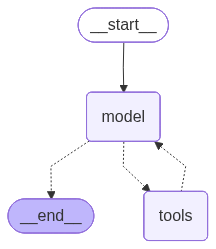

In [29]:
from langchain.agents import create_agent

# Extract the system message from the prompt template
system_message = """Respond to the human as helpfully and accurately as possible. You have access to the following tools:

{tools}

Use a json blob to specify a tool use. Specifically, this json blob must be the last thing in your response before a newline. Here is the schema:
```
{"tool": <tool name>, "tool_input": <parameters>}
```

Always include a `tool_input` key in the blob, even if it is an empty dict.

Respond in the same language the human is using."""

# Create the agent with the model, tools, and system prompt
agent = create_agent(model, tools, system_prompt=system_message)
agent

In [34]:
# The agent created with create_agent is a compiled state graph that can be invoked directly
# No need for AgentExecutor - just invoke the agent with input
from langchain_core.messages import HumanMessage

result = agent.invoke({"messages": [HumanMessage(content="What is Rockchip RKNN?")]})
print(f"Final Response: {result}")


Final Response: {'messages': [HumanMessage(content='What is Rockchip RKNN?', additional_kwargs={}, response_metadata={}, id='d67ae08b-c9f1-46bc-938a-3ad86857f744'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '8wkqg5xty', 'function': {'arguments': '{"query":"What is Rockchip RKNN?"}', 'name': 'rockchip_rknn'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 486, 'total_tokens': 535, 'completion_time': 0.085147273, 'completion_tokens_details': None, 'prompt_time': 0.026866446, 'prompt_tokens_details': None, 'queue_time': 0.005112784, 'total_time': 0.112013719}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bfd52-5232-75f3-b48f-a51fe3802a48-0', tool_calls=[{'name': 'rockchip_rknn', 'args': {'query': 'What is Rockchip RKNN?'}, 'id': '8wkqg5xty', 'type': 'tool_call'}], in

# Adding in memory

As mentioned earlier, this agent is stateless. This means it does not remember previous interactions. To give it memory we need to pass in previous chat_history. Note: it needs to be called chat_history because of the prompt we are using. If we use a different prompt, we could change the variable name

In [36]:
from langchain_core.messages import HumanMessage, AIMessage

# Create an AgentExecutor-like wrapper for memory support
class AgentExecutor:
    def __init__(self, agent, tools):
        self.agent = agent
        self.tools = tools
        self.chat_history = []
    
    def invoke(self, input_dict):
        """
        Invoke the agent with memory support
        input_dict should contain:
        - "input": the user's question
        - "chat_history": list of previous messages (optional)
        """
        user_input = input_dict.get("input", "")
        chat_history = input_dict.get("chat_history", [])
        
        # Combine chat history with current input
        messages = chat_history + [HumanMessage(content=user_input)]
        
        # Invoke the agent
        result = self.agent.invoke({"messages": messages})
        
        # Store in memory
        self.chat_history = messages
        if isinstance(result, dict) and "messages" in result:
            self.chat_history.extend(result["messages"])
        
        return result

# Create agent executor with memory
agent_executor = AgentExecutor(agent=agent, tools=tools)

# Test with memory
response = agent_executor.invoke({"input": "hi! my name is Abdullah", "chat_history": []})
print("Response:", response)

Response: {'messages': [HumanMessage(content='hi! my name is Abdullah', additional_kwargs={}, response_metadata={}, id='cccbb27d-f33b-4195-a4c9-65bd10c78571'), AIMessage(content="Nice to meet you, Abdullah! What brings you here today? Do you have any questions or topics you'd like to discuss?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 485, 'total_tokens': 512, 'completion_time': 0.038273666, 'completion_tokens_details': None, 'prompt_time': 0.026852429, 'prompt_tokens_details': None, 'queue_time': 0.005082782, 'total_time': 0.065126095}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ff2b098aaf', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bfd59-a9f5-7042-a0cb-d34c0c54f5d8-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 485, 'output_tokens': 27, 'total_tokens': 512})]}


In [37]:
agent_executor.invoke({"input": "hi! my name is Abdullah", "chat_history": []})

{'messages': [HumanMessage(content='hi! my name is Abdullah', additional_kwargs={}, response_metadata={}, id='7b2f63b0-7fa8-47cc-b90a-566346aabdbc'),
  AIMessage(content="Nice to meet you, Abdullah! It's great to have you here. Is there anything I can help you with, or would you like to chat for a bit? \n\n{tools}", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 39, 'prompt_tokens': 485, 'total_tokens': 524, 'completion_time': 0.051938676, 'completion_tokens_details': None, 'prompt_time': 0.026732092, 'prompt_tokens_details': None, 'queue_time': 0.004979462, 'total_time': 0.078670768}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ff2b098aaf', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bfd5a-4b56-7070-960d-c733508cc969-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 485, 'output_tokens': 39, 'total_tokens': 524})]}

In [38]:
from langchain_core.messages import AIMessage, HumanMessage

In [40]:
agent_executor.invoke(
    {
        "chat_history": [
            HumanMessage(content="hi! my name is Abdullah"),
            AIMessage(content="Hello Abdullah! How can I assist you today?"),
        ],
        "input": "what's my name?",
    }
)

{'messages': [HumanMessage(content='hi! my name is Abdullah', additional_kwargs={}, response_metadata={}, id='2ec0f983-94b0-4694-9b80-91455b524c5a'),
  AIMessage(content='Hello Abdullah! How can I assist you today?', additional_kwargs={}, response_metadata={}, id='f150f165-58f3-4fcd-889b-e2681345cd43', tool_calls=[], invalid_tool_calls=[]),
  HumanMessage(content="what's my name?", additional_kwargs={}, response_metadata={}, id='524ad666-7901-46cb-81bb-dbb43cc15ec6'),
  AIMessage(content='Your name is Abdullah.\n\n{tool: "answer", "tool_input": {"question": "what\'s my name?", "context": {"name": "Abdullah"}}}', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 510, 'total_tokens': 547, 'completion_time': 0.065027335, 'completion_tokens_details': None, 'prompt_time': 0.027980487, 'prompt_tokens_details': None, 'queue_time': 0.005129067, 'total_time': 0.093007822}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_1151d4f23c

In [41]:
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory

store = {}


def get_session_history(session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = ChatMessageHistory()
    return store[session_id]

In [ ]:
# Wrap the agent (not the AgentExecutor) with message history
# The agent itself is a Runnable, so it works with RunnableWithMessageHistory
agent_with_chat_history = RunnableWithMessageHistory(
    agent,  # Use the agent directly, not agent_executor
    get_session_history,
    input_messages_key="messages",
    history_messages_key="messages",
)

# Test it - invoke with session_id for automatic history management
response = agent_with_chat_history.invoke(
    {"messages": [HumanMessage(content="Hi! My name is Umair")]},
    config={"configurable": {"session_id": "user123"}}
)
print("Response:", response)

AttributeError: 'AgentExecutor' object has no attribute 'with_listeners'